In [1]:
import os
import numpy as np
import pandas as pd
import anndata as ad
import tifffile as tif
import matplotlib.pyplot as plt

from tqdm import tqdm
from tqdm.notebook import trange
from scipy.spatial import distance
from matplotlib.collections import PatchCollection, LineCollection
from matplotlib.patches import Rectangle

def closest_node(node, nodes):
    closest_index = distance.cdist([node], nodes).argmin()
    return nodes[closest_index], closest_index


In [19]:

base_path = '/home/unix/jiahao/wanglab/Data/Analyzed/2023-10-01-Jiahao-Test/mAD_64/'
image_path = os.path.join(base_path, 'images')
expr_path = os.path.join(base_path, 'expr')
clustermap_path = os.path.join(expr_path, 'clustermap')
clustermap_fused_path = os.path.join(clustermap_path, 'fused')
if not os.path.exists(clustermap_fused_path):
    os.mkdir(clustermap_fused_path)

img_col, img_row = [3072, 3072]

In [20]:
def parse_tile_configuration(input_file):
    import re

    f = open(input_file)
    line = f.readline()
    records = []
    a = 0
    while line:
        if a > 3:
            match = re.match(r"^(?P<fov>.*).tif; ; \((?P<col>.*), (?P<row>.*)\)", line)
            current_record = [match.group('fov'), match.group('col'), match.group('row')]
            records.append(current_record)
        a += 1
        line = f.readline()
    records = np.array(records)
    f.close()
    tile_config = pd.DataFrame(records, columns=['fov','col','row'])
    tile_config['col'] = (tile_config['col'].astype(float) + 0.5).astype(int)
    tile_config['row'] = (tile_config['row'].astype(float) + 0.5).astype(int)
    return tile_config

In [21]:
tile_config_original = parse_tile_configuration(os.path.join(image_path, 'protein/PI/TileConfiguration.txt'))
tile_config_registered = parse_tile_configuration(os.path.join(image_path, 'protein/PI/TileConfiguration.registered.txt'))

In [22]:
tile_config_combined = pd.concat([tile_config_original, tile_config_registered], axis=1)
tile_config_combined = tile_config_original.join(tile_config_registered, lsuffix='_org', rsuffix='_reg')
tile_config_combined = tile_config_combined.drop('fov_reg', axis=1)
tile_config_combined.columns = ['fov', 'col', 'row', 'col_registered', 'row_registered']
tile_config_combined['id'] = tile_config_combined['fov'].str.extract(r'(?P<digit>\d+)').astype(int)

# load grid file 
grid_df = pd.read_csv(os.path.join(base_path, 'grid.csv'), index_col=0)
grid_df.columns = ['col_count', 'row_count', 'id', 'grid']

tile_config_without_blank = tile_config_combined.loc[tile_config_combined['id'] > 0, :]

min_column, min_row = [tile_config_without_blank['col_registered'].min(), tile_config_without_blank['row_registered'].min()]
max_column, max_row = [tile_config_without_blank['col_registered'].max(), tile_config_without_blank['row_registered'].max()]
shape_column, shape_row = [max_column - min_column + img_col, max_row - min_row + img_row]

tile_config_final = tile_config_combined.copy()
tile_config_final['col_registered'] = tile_config_final['col_registered'] - min_column
tile_config_final['row_registered'] = tile_config_final['row_registered'] - min_row
tile_config_final = pd.merge(tile_config_final, grid_df, on='id', how='outer')
tile_config_final.to_csv(os.path.join(clustermap_fused_path, 'tile_config.csv'))

  0%|          | 0/56 [00:00<?, ?it/s]

	cells in cell_centers: 0 | cells in spots: 0
	New total number of cell centers: 329
	New total number of assigned reads: 80356
	New total number of background reads: 41002
	cells in cell_centers: 321 | cells in spots: 321
	New total number of cell centers: 657
	New total number of assigned reads: 162448
	New total number of background reads: 80296
	cells in cell_centers: 643 | cells in spots: 643
	New total number of cell centers: 986
	New total number of assigned reads: 237544
	New total number of background reads: 119519
	cells in cell_centers: 963 | cells in spots: 963
	New total number of cell centers: 1305
	New total number of assigned reads: 297702
	New total number of background reads: 139499
	cells in cell_centers: 1295 | cells in spots: 1295
	New total number of cell centers: 1587
	New total number of assigned reads: 350146
	New total number of background reads: 154014
	cells in cell_centers: 1574 | cells in spots: 1574
	New total number of cell centers: 1926
	New total numbe

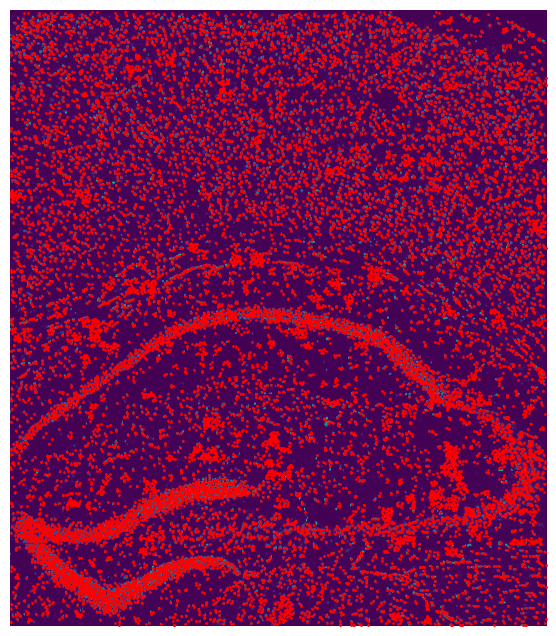

In [36]:
# spot_location_1 - col - x
# spot_location_2 - row - y

fused_pi = tif.imread(os.path.join(image_path, 'fused/PI.tif'))

assigned_spots = pd.DataFrame({'spot_location_1':[], 'spot_location_2':[], 'spot_location_3':[],
                             'gene':[], 'cell_barcode':[]})
background_spots = pd.DataFrame({'spot_location_1':[], 'spot_location_2':[], 'spot_location_3':[],
                             'gene':[], 'cell_barcode':[]})
cell_centers = pd.DataFrame({'cell_barcode':[], 'column':[], 'row':[], 'z_axis':[]})

rectangle_list = []
middle_edge_list = []

cell_barcode_min = 0
for i in trange(tile_config_final.shape[0]):
# for i in trange(2):
    current_record = tile_config_final.iloc[i, :]
    current_fov = current_record['fov']
    current_id = current_record['id']
    current_col_registered = current_record['col_registered']
    current_row_registered = current_record['row_registered']
    current_col_count = current_record['col_count']
    current_row_count = current_record['row_count']

    current_rectangle = Rectangle((current_col_registered, current_row_registered), img_col, img_row)
    rectangle_list.append(current_rectangle)
    
    if current_id > 0:

        # load clustermap spots
        current_spots = pd.read_csv(os.path.join(clustermap_path, f'{current_fov}_spots.csv'))
        current_spots['gene'] = current_spots['gene'] - 1
        current_spots['spot_location_1'] = current_spots['spot_location_1'] - 1
        current_spots['spot_location_2'] = current_spots['spot_location_2'] - 1
        current_spots['spot_location_3'] = current_spots['spot_location_3'] - 1

        # load clustermap cell_centers
        current_cell_centers = pd.read_csv(os.path.join(clustermap_path, f'{current_fov}_cell_center.csv'), index_col=0)

        # add offsets
        current_spots['spot_location_1'] = current_spots['spot_location_1'] + current_col_registered
        current_cell_centers['column'] = current_cell_centers['column'] + current_col_registered

        current_spots['spot_location_2'] = current_spots['spot_location_2'] + current_row_registered
        current_cell_centers['row'] = current_cell_centers['row'] + current_row_registered
    
        if current_col_count == 0:
            pass
        else:
            # left tile exists
            left_col_count = current_col_count - 1
            left_record = tile_config_final.loc[(tile_config_final['col_count'] == left_col_count) & (tile_config_final['row_count'] == current_row_count), :]
            middle_edge = int((left_record['col_registered'] + img_col - current_col_registered)/2 + 0.5)

            if middle_edge >= 0: 
                    current_col_registered = middle_edge + current_col_registered
                    middle_edge_list.append([(current_col_registered, current_row_registered), (current_col_registered, current_row_registered + img_row)])
            
        if current_row_count == 0:
            pass
        else:
            # upper tile exists
            up_row_count = current_row_count - 1
            up_record = tile_config_final.loc[(tile_config_final['row_count'] == up_row_count) & (tile_config_final['col_count'] == current_col_count), :]
            middle_edge = int((up_record['row_registered'] + img_row - current_row_registered)/2 + 0.5)

            if middle_edge >= 0: 
                    current_row_registered = middle_edge + current_row_registered
                    middle_edge_list.append([(current_col_registered, current_row_registered), (current_col_registered + img_col, current_row_registered)])

        # modify cell barcode
        current_spots['cell_barcode'] =  current_spots['clustermap'].values
        current_spots = current_spots.drop(columns=['clustermap'])
        # print(current_spots.shape)
        current_assigned_spots = current_spots.loc[current_spots['cell_barcode'] != -1, :].copy()
        # print(current_assigned_spots.shape)
        current_background_spots = current_spots.loc[current_spots['cell_barcode'] == -1, :].copy()
        # print(current_background_spots.shape)

        # remap cell barcode
        cell_barcode_dict = {}
        for j, k in enumerate(current_cell_centers['cell_barcode'].unique()):
            cell_barcode_dict[k] = j
        current_cell_centers['cell_barcode'] = current_cell_centers['cell_barcode'].map(cell_barcode_dict)
        current_assigned_spots['cell_barcode'] = current_assigned_spots['cell_barcode'].map(cell_barcode_dict)

        # change cell barcode
        current_cell_centers['cell_barcode'] = current_cell_centers['cell_barcode'] + cell_barcode_min
        current_assigned_spots['cell_barcode'] = current_assigned_spots['cell_barcode'] + cell_barcode_min

        ## keep the cells within upper_left_new for `remain_reads`, `cell_center`
        cell_centers = cell_centers.loc[(cell_centers['column'] <= current_col_registered) | (cell_centers['row'] <= current_row_registered) | (cell_centers['row'] >= current_row_registered + img_row), :] 
        assigned_spots = assigned_spots.loc[assigned_spots['cell_barcode'].isin(cell_centers['cell_barcode']), :]
        background_spots = background_spots.loc[(background_spots['spot_location_1'] <= current_col_registered) | (background_spots['spot_location_2'] <= current_row_registered) | (background_spots['spot_location_2'] >= current_row_registered + img_row), :] 
        # print(f"\tcells in cell_centers: {cell_centers['cell_barcode'].nunique()} | cells in spots: {assigned_spots['cell_barcode'].nunique()}")

        ## keep the cells beyond upper_left_new for `current_spots`, `current_cell_centers`
        current_cell_centers = current_cell_centers.loc[(current_cell_centers['column'] > current_col_registered) & (current_cell_centers['row'] > current_row_registered), :]
        current_assigned_spots = current_assigned_spots.loc[current_assigned_spots['cell_barcode'].isin(current_cell_centers['cell_barcode']), :]
        current_background_spots = current_background_spots.loc[(current_background_spots['spot_location_1'] > current_col_registered) & (current_background_spots['spot_location_2'] > current_row_registered), :]
        
        # append
        cell_centers = pd.concat((cell_centers, current_cell_centers), axis=0)
        print(f"\tNew total number of cell centers: {len(cell_centers)}")
        assigned_spots = pd.concat((assigned_spots, current_assigned_spots), axis=0)
        print(f"\tNew total number of assigned reads: {len(assigned_spots)}")
        background_spots = pd.concat((background_spots, current_background_spots), axis=0)
        print(f"\tNew total number of background reads: {len(background_spots)}")
        
        # Update minimum cell barcode
        if current_cell_centers.shape[0] > 0:
            cell_barcode_min = cell_centers['cell_barcode'].max() + 1

    else:
        continue

    
fig, ax = plt.subplots(figsize=(7,8))
ax.imshow(fused_pi)
ax.scatter(cell_centers.loc[:,'column'], cell_centers.loc[:,'row'], c='r', s=1)
plt.axis('off')
plt.show()

In [8]:
cell_ids = assigned_spots['cell_barcode']
cells_unique = np.unique(cell_ids)
spots_repr = np.array(assigned_spots[['spot_location_1', 'spot_location_2']])[cell_ids >= 0]
cell_ids = cell_ids[cell_ids >= 0]                
cmap = np.random.rand(int(max(cell_ids)+1), 3)

fig, ax = plt.subplots(figsize=[35, 40])
ax.imshow(fused_pi)
ax.scatter(spots_repr[:, 0], spots_repr[:, 1], s=1, c=cmap[[int(x) for x in cell_ids]], alpha=0.2)
ax.scatter(background_spots.loc[:, 'spot_location_1'], background_spots.loc[:, 'spot_location_2'], s=1, c='green', alpha=0.2)
ax.scatter(cell_centers.loc[:, 'column'], cell_centers.loc[:, 'row'], s=3, c='red', alpha = 0.7)

p = PatchCollection(rectangle_list, ec="yellow", facecolor='none')
l = LineCollection(middle_edge_list, colors='yellow', linestyle='dashed')
plt.gca().add_collection(p)
plt.gca().add_collection(l)
ax.set_aspect('equal')
ax.axis('off')
fig.tight_layout()
clustermap_figure_name = os.path.join(clustermap_fused_path, "clustermap_fused.tif")
plt.savefig(clustermap_figure_name)
plt.clf()
plt.close()
# plt.show()

In [37]:

# filter the repeated reads
assigned_spots = assigned_spots.drop(columns=['is_noise'])
assigned_spots = assigned_spots.drop_duplicates(subset = None, keep = 'first')

background_spots = background_spots.drop(columns=['is_noise'])
background_spots = background_spots.drop(columns=['cell_barcode'])
background_spots = background_spots.drop_duplicates(subset = None, keep = 'first')

# reset index
cell_centers.reset_index(inplace = True, drop = True)
assigned_spots.reset_index(inplace = True, drop = True)
background_spots.reset_index(inplace = True, drop = True)

# transfer float to integer
assigned_spots['spot_location_1'] = assigned_spots['spot_location_1'].astype(int)
assigned_spots['spot_location_2'] = assigned_spots['spot_location_2'].astype(int)
assigned_spots['spot_location_3'] = assigned_spots['spot_location_3'].astype(int)
assigned_spots['cell_barcode'] = assigned_spots['cell_barcode'].astype(int)

background_spots['spot_location_1'] = background_spots['spot_location_1'].astype(int)
background_spots['spot_location_2'] = background_spots['spot_location_2'].astype(int)
background_spots['spot_location_3'] = background_spots['spot_location_3'].astype(int)

cell_centers['column'] = cell_centers['column'].astype(int)
cell_centers['row'] = cell_centers['row'].astype(int)
cell_centers['z_axis'] = cell_centers['z_axis'].astype(int)
cell_centers['cell_barcode'] = cell_centers['cell_barcode'].astype(int)

# deal with multi-assigned reads
# find duplicated reads
assigned_spots_check = assigned_spots.loc[:, ['spot_location_1', 'spot_location_2', 'spot_location_3']]
assigned_spots_check.columns = ['col','row','z']
assigned_spots_check['coors'] = assigned_spots_check['col'].apply(str).str.cat(assigned_spots_check['row'].apply(str),sep='-').str.cat(assigned_spots_check['z'].apply(str),sep='-')
assigned_spots_check_counts = assigned_spots_check['coors'].value_counts()
repeat_spots = assigned_spots_check_counts[assigned_spots_check_counts > 1]

# assign the duplicated reads to the closest cell
filter_index = []
for i in trange(len(repeat_spots)):

    repeat_spots_index = assigned_spots_check.index[assigned_spots_check['coors'] == repeat_spots.index[i]]
    vec1 = assigned_spots.loc[repeat_spots_index[0], ['spot_location_1', 'spot_location_2', 'spot_location_3']].tolist()
    repeat_spots_cell_index = cell_centers['cell_barcode'].isin(assigned_spots.loc[repeat_spots_index, 'cell_barcode'])
    repeat_spots_cell = cell_centers.loc[repeat_spots_cell_index, :]
    closest_index = closest_node(vec1, np.array(repeat_spots_cell.loc[:, ['column','row','z_axis']]).tolist())[1]
    selected_cell = repeat_spots_cell.iloc[closest_index, 0]
    filter_index.extend(repeat_spots_index[np.logical_not(assigned_spots.loc[repeat_spots_index, 'cell_barcode'] == selected_cell)].tolist())

print("read counts before filtering multi-assigned reads: " + str(assigned_spots.shape[0]))
assigned_spots.drop(index = filter_index, inplace = True)
assigned_spots.reset_index(inplace = True, drop = True)
print("read counts after filtering multi-assigned reads: " + str(assigned_spots.shape[0]))

# remove cells without reads 
cell_centers = cell_centers.loc[cell_centers['cell_barcode'].isin(assigned_spots['cell_barcode']), :]

# remap cell barcodes 
cell_barcode_dict = {}
for j, k in enumerate(cell_centers['cell_barcode'].unique()):
    cell_barcode_dict[k] = j
cell_centers['cell_barcode'] = cell_centers['cell_barcode'].map(cell_barcode_dict)
assigned_spots['cell_barcode'] = assigned_spots['cell_barcode'].map(cell_barcode_dict)

# save output
cell_centers.to_csv(os.path.join(clustermap_fused_path, 'cell_centers.csv'))
assigned_spots.to_csv(os.path.join(clustermap_fused_path, 'assigned_spots.csv'))
background_spots.to_csv(os.path.join(clustermap_fused_path, 'background_spots.csv'))

  0%|          | 0/19 [00:00<?, ?it/s]

read counts before filtering multi-assigned reads: 3113341
read counts after filtering multi-assigned reads: 3113322


In [48]:
# Read in reads assignment results
gene_path = os.path.join(base_path, 'genes.csv')
gene_names = pd.read_csv(gene_path, header=None, names=["gene", "barcode"])["gene"]

cell_center_index = cell_centers.copy()
cell_center_index.set_index('cell_barcode', inplace=True, drop=True) 
assigned_spots_t = assigned_spots.loc[:, ['cell_barcode', 'gene_name']]
assigned_spots_t['value'] = 1

# Create cell-by-gene expression matrix
exp_matrix = pd.pivot_table(assigned_spots_t, index='cell_barcode', columns='gene_name', aggfunc='count', fill_value = 0)
var_raw = [str(s2) for (s1,s2) in exp_matrix.columns.tolist()]
exp_matrix = exp_matrix.set_axis(var_raw, axis = 1, copy=False)
obs = cell_center_index.loc[exp_matrix.index.values, ['column','row','z_axis']]
obs.reset_index(inplace=True, drop=True) ### obs as cell location
var = pd.DataFrame(index=var_raw)  ## index as gene name

# Store in anndata object
adata = ad.AnnData(X=np.array(exp_matrix),
                var=var,
                obs=obs)

adata

/home/unix/jiahao/anaconda3/envs/starfinder/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 16637 × 64
    obs: 'column', 'row', 'z_axis'

In [52]:
from datetime import datetime
date = datetime.today().strftime('%Y-%m-%d')
adata.write_h5ad(os.path.join(expr_path, f"{date}-mAD_64_clustermap.h5ad"))